# Reconocimiento de Objetos del Salón - 20242595001 (MEJORADO)

Este notebook implementa:
1. **Autoencoder**: Para aprender representaciones comprimidas de las imágenes
2. **Clasificador CNN SIMPLIFICADO**: Optimizado para datasets pequeños

## Mejoras aplicadas:
- ✅ Modelo más simple para evitar overfitting
- ✅ Data augmentation más agresivo
- ✅ Batch size reducido
- ✅ Regularización L2
- ✅ Mejor configuración de hiperparámetros

## Objetos a detectar:
- teclado
- mouse
- pantalla
- cpu
- silla
- mesa
- nada

In [1]:
# Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuración
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponible: []


## 1. Cargar y Preparar Datos

In [2]:
# Configuración de rutas - OPTIMIZADO PARA DATASET PEQUEÑO
DATA_DIR = '../data/processed'
MODEL_DIR = '../models'
IMG_SIZE = 128  # Reducido de 224 a 128 para evitar overfitting
BATCH_SIZE = 4  # Muy pequeño para dataset pequeño
LATENT_DIM = 32  # Reducido para evitar overfitting

# Clases
CLASSES = ['teclado', 'mouse', 'pantalla', 'cpu', 'silla', 'mesa', 'nada']
NUM_CLASSES = len(CLASSES)

print(f"Número de clases: {NUM_CLASSES}")
print(f"Clases: {CLASSES}")
print(f"\n⚡ Configuración optimizada para dataset PEQUEÑO:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE} (reducido para menos parámetros)")
print(f"  Batch size: {BATCH_SIZE} (muy pequeño)")
print(f"  Latent dim: {LATENT_DIM} (reducido)")

Número de clases: 7
Clases: ['teclado', 'mouse', 'pantalla', 'cpu', 'silla', 'mesa', 'nada']

⚡ Configuración optimizada para dataset PEQUEÑO:
  Image size: 128x128 (reducido para menos parámetros)
  Batch size: 4 (muy pequeño)
  Latent dim: 32 (reducido)


In [3]:
def load_images_from_folder(folder, img_size=128):
    """
    Carga todas las imágenes de una carpeta
    """
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(CLASSES):
        class_path = os.path.join(folder, class_name)
        
        if not os.path.exists(class_path):
            print(f"⚠️  Advertencia: No se encontró la carpeta {class_path}")
            continue
        
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Cargando {len(image_files)} imágenes de {class_name}...")
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            # Convertir BGR a RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Redimensionar
            img = cv2.resize(img, (img_size, img_size))
            
            images.append(img)
            labels.append(class_idx)
    
    return np.array(images), np.array(labels)

# Cargar todas las imágenes
print("Cargando imágenes...")
X, y = load_images_from_folder(DATA_DIR, IMG_SIZE)

print(f"\n✅ Total de imágenes cargadas: {len(X)}")
print(f"Shape de las imágenes: {X.shape}")
print(f"Shape de las etiquetas: {y.shape}")

# Distribución de clases
print(f"\n📊 Distribución por clase:")
unique, counts = np.unique(y, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"  {CLASSES[class_idx]}: {count} imágenes")

if len(X) < 50:
    print(f"\n⚠️  ADVERTENCIA: Solo tienes {len(X)} imágenes.")
    print(f"   Para mejores resultados, necesitas al menos 20-30 frames por clase.")
    print(f"   Considera extraer más frames ejecutando: python extract_frames.py")

Cargando imágenes...
Cargando 9 imágenes de teclado...
Cargando 10 imágenes de mouse...
Cargando 10 imágenes de pantalla...
Cargando 9 imágenes de cpu...
Cargando 10 imágenes de silla...
Cargando 11 imágenes de mesa...
Cargando 9 imágenes de nada...

✅ Total de imágenes cargadas: 68
Shape de las imágenes: (68, 128, 128, 3)
Shape de las etiquetas: (68,)

📊 Distribución por clase:
  teclado: 9 imágenes
  mouse: 10 imágenes
  pantalla: 10 imágenes
  cpu: 9 imágenes
  silla: 10 imágenes
  mesa: 11 imágenes
  nada: 9 imágenes


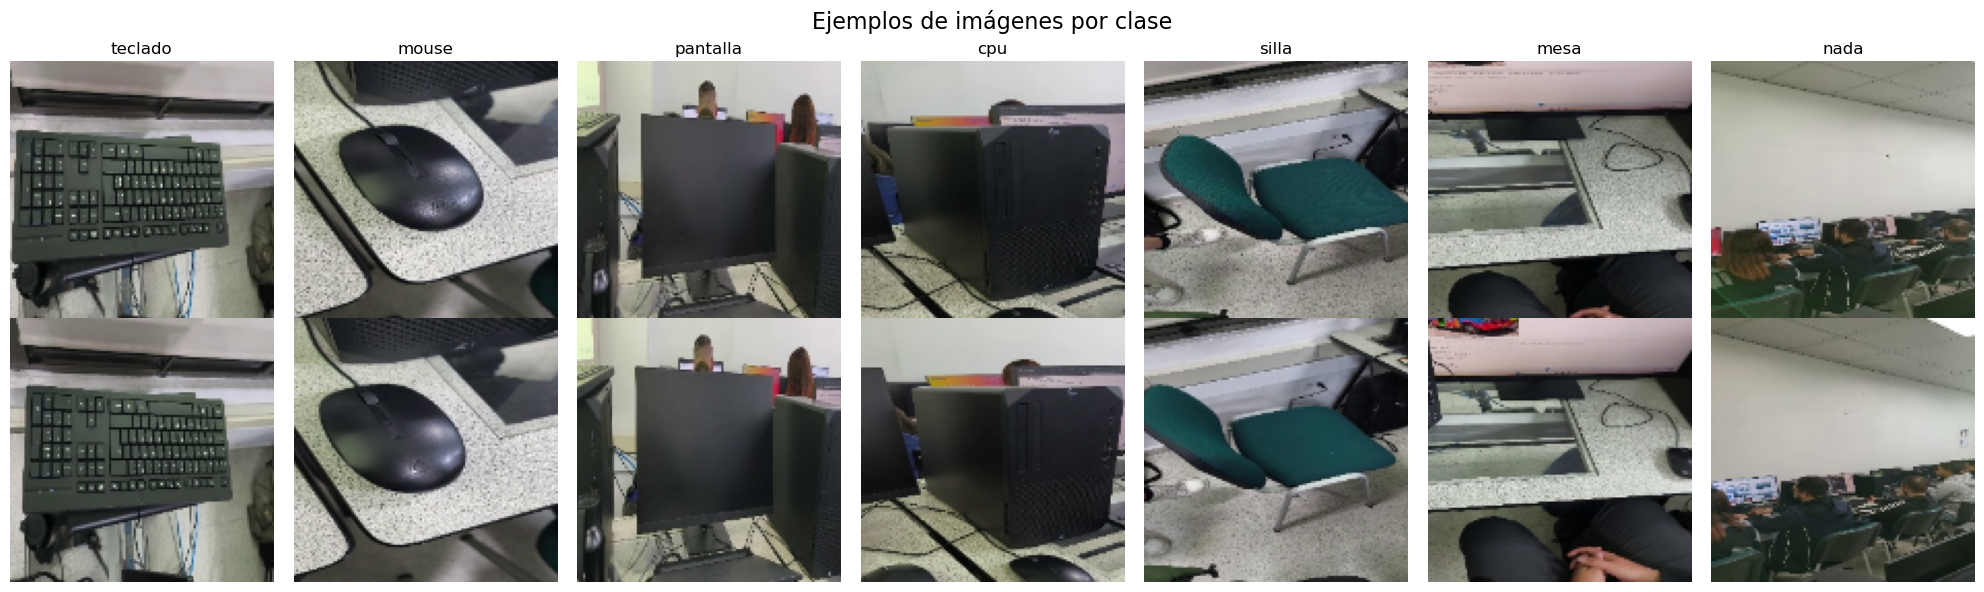

In [4]:
# Visualizar algunas imágenes de ejemplo
fig, axes = plt.subplots(2, 7, figsize=(20, 6))
fig.suptitle('Ejemplos de imágenes por clase', fontsize=16)

for class_idx, class_name in enumerate(CLASSES):
    class_indices = np.where(y == class_idx)[0]
    
    if len(class_indices) > 0:
        for i in range(2):
            if i < len(class_indices):
                idx = class_indices[i]
                axes[i, class_idx].imshow(X[idx])
                axes[i, class_idx].axis('off')
                if i == 0:
                    axes[i, class_idx].set_title(class_name)

plt.tight_layout()
plt.show()

In [5]:
# Normalizar imágenes a rango [0, 1]
X_normalized = X.astype('float32') / 255.0

# Dividir con validación más pequeña para datasets pequeños
test_size = 0.15 if len(X) < 100 else 0.2

X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y, test_size=test_size, random_state=42, stratify=y
)

print(f"✅ Conjunto de entrenamiento: {X_train.shape}")
print(f"✅ Conjunto de validación: {X_val.shape}")

# Convertir etiquetas a one-hot encoding
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)

print(f"\nEtiquetas one-hot:")
print(f"  Train: {y_train_cat.shape}")
print(f"  Val: {y_val_cat.shape}")

✅ Conjunto de entrenamiento: (57, 128, 128, 3)
✅ Conjunto de validación: (11, 128, 128, 3)

Etiquetas one-hot:
  Train: (57, 7)
  Val: (11, 7)


## 2. Construcción del Autoencoder SIMPLIFICADO

Modelo más simple para evitar overfitting con pocos datos.

In [6]:
def build_encoder_simple(input_shape=(128, 128, 3), latent_dim=32):
    """
    Construye un encoder SIMPLIFICADO
    """
    inputs = layers.Input(shape=input_shape)
    
    # Bloque 1
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # 64x64
    
    # Bloque 2
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 32x32
    
    # Bloque 3
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 16x16
    
    # Espacio latente
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)
    
    encoder = models.Model(inputs, latent, name='encoder')
    return encoder

def build_decoder_simple(latent_dim=32, output_shape=(128, 128, 3)):
    """
    Construye un decoder SIMPLIFICADO
    """
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    # Decodificar
    x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    
    # Bloque 1
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)  # 32x32
    
    # Bloque 2
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)  # 64x64
    
    # Bloque 3
    x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x)  # 128x128
    
    # Salida
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    decoder = models.Model(latent_inputs, outputs, name='decoder')
    return decoder

def build_autoencoder(input_shape=(128, 128, 3), latent_dim=32):
    """
    Construye el autoencoder completo
    """
    encoder = build_encoder_simple(input_shape, latent_dim)
    decoder = build_decoder_simple(latent_dim, input_shape)
    
    inputs = layers.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = models.Model(inputs, decoded, name='autoencoder')
    
    return autoencoder, encoder, decoder

In [7]:
# Construir el autoencoder
autoencoder, encoder, decoder = build_autoencoder(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    latent_dim=LATENT_DIM
)

print("="*60)
print("AUTOENCODER SIMPLIFICADO:")
print("="*60)
autoencoder.summary()

AUTOENCODER SIMPLIFICADO:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       547,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │       601,123 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149,027 (4.38 MB)

 Trainable params: 1,149,027 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compilar el autoencoder
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
callbacks_ae = [
    ModelCheckpoint(
        os.path.join(MODEL_DIR, '20242595001_autoencoder.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Autoencoder compilado y listo para entrenar")

✅ Autoencoder compilado y listo para entrenar


In [9]:
# Entrenar el autoencoder
print("🚀 Entrenando autoencoder...\n")

history_ae = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks_ae,
    verbose=1
)

🚀 Entrenando autoencoder...

Epoch 1/100
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0746 - mae: 0.2446
Epoch 1: val_loss improved from None to 0.07367, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0723 - mae: 0.2391 - val_loss: 0.0737 - val_mae: 0.2429 - learning_rate: 0.0010
Epoch 2/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0735 - mae: 0.2438
Epoch 2: val_loss improved from 0.07367 to 0.07118, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0706 - mae: 0.2371 - val_loss: 0.0712 - val_mae: 0.2397 - learning_rate: 0.0010
Epoch 3/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0704 - mae: 0.2400
Epoch 3: val_loss improved from 0.07118 to 0.06771, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0674 - mae: 0.2329 - val_loss: 0.0677 - val_mae: 0.2337 - learning_rate: 0.0010
Epoch 4/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0662 - mae: 0.2323
Epoch 4: val_loss improved from 0.06771 to 0.06140, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0622 - mae: 0.2203 - val_loss: 0.0614 - val_mae: 0.2220 - learning_rate: 0.0010
Epoch 5/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0577 - mae: 0.2121
Epoch 5: val_loss improved from 0.06140 to 0.05134, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0521 - mae: 0.1947 - val_loss: 0.0513 - val_mae: 0.1839 - learning_rate: 0.0010
Epoch 6/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486 - mae: 0.1797
Epoch 6: val_loss improved from 0.05134 to 0.04340, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0453 - mae: 0.1740 - val_loss: 0.0434 - val_mae: 0.1652 - learning_rate: 0.0010
Epoch 7/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0434 - mae: 0.1669
Epoch 7: val_loss did not improve from 0.04340
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0413 - mae: 0.1642 - val_loss: 0.0445 - val_mae: 0.1662 - learning_rate: 0.0010
Epoch 8/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0421 - mae: 0.1642
Epoch 8: val_loss improved from 0.04340 to 0.04114, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0403 - mae: 0.1613 - val_loss: 0.0411 - val_mae: 0.1617 - learning_rate: 0.0010
Epoch 9/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0394 - mae: 0.1591
Epoch 9: val_loss improved from 0.04114 to 0.03861, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0377 - mae: 0.1551 - val_loss: 0.0386 - val_mae: 0.1538 - learning_rate: 0.0010
Epoch 10/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0363 - mae: 0.1492
Epoch 10: val_loss improved from 0.03861 to 0.03545, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0351 - mae: 0.1467 - val_loss: 0.0354 - val_mae: 0.1444 - learning_rate: 0.0010
Epoch 11/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0324 - mae: 0.1392
Epoch 11: val_loss improved from 0.03545 to 0.03403, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0324 - mae: 0.1400 - val_loss: 0.0340 - val_mae: 0.1393 - learning_rate: 0.0010
Epoch 12/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0297 - mae: 0.1307
Epoch 12: val_loss improved from 0.03403 to 0.03365, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0304 - mae: 0.1337 - val_loss: 0.0336 - val_mae: 0.1420 - learning_rate: 0.0010
Epoch 13/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0285 - mae: 0.1284
Epoch 13: val_loss did not improve from 0.03365
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0292 - mae: 0.1308 - val_loss: 0.0341 - val_mae: 0.1390 - learning_rate: 0.0010
Epoch 14/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0280 - mae: 0.1269
Epoch 14: val_loss did not improve from 0.03365
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0286 - mae: 0.1297 - val_loss: 0.0339 - val_mae: 0.1349 - learning_rate: 0.0010
Epoch 15/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0255 - mae: 0.1191
Epoch 15: val_loss improved from 0.03365 to 0.03285, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0262 - mae: 0.1224 - val_loss: 0.0329 - val_mae: 0.1326 - learning_rate: 0.0010
Epoch 16/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237 - mae: 0.1133
Epoch 16: val_loss improved from 0.03285 to 0.03218, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0250 - mae: 0.1184 - val_loss: 0.0322 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 17/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - mae: 0.1097
Epoch 17: val_loss improved from 0.03218 to 0.03135, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0237 - mae: 0.1147 - val_loss: 0.0314 - val_mae: 0.1307 - learning_rate: 0.0010
Epoch 18/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - mae: 0.1086
Epoch 18: val_loss improved from 0.03135 to 0.02984, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0231 - mae: 0.1130 - val_loss: 0.0298 - val_mae: 0.1256 - learning_rate: 0.0010
Epoch 19/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0206 - mae: 0.1036
Epoch 19: val_loss did not improve from 0.02984
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0217 - mae: 0.1082 - val_loss: 0.0305 - val_mae: 0.1254 - learning_rate: 0.0010
Epoch 20/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0204 - mae: 0.1036
Epoch 20: val_loss did not improve from 0.02984
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0215 - mae: 0.1081 - val_loss: 0.0301 - val_mae: 0.1248 - learning_rate: 0.0010
Epoch 21/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - mae: 0.1020
Epoch 21: val_loss did not improve from 0.02984
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0213 - mae: 0.1069 - val_loss: 0.0304 - val_mae: 0.1262 - learning_rate: 0.0010
Epoch 22/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - mae: 0.0986
Epoch 22

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0200 - mae: 0.1030 - val_loss: 0.0289 - val_mae: 0.1220 - learning_rate: 0.0010
Epoch 23/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0179 - mae: 0.0949
Epoch 23: val_loss improved from 0.02893 to 0.02827, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0190 - mae: 0.1004 - val_loss: 0.0283 - val_mae: 0.1199 - learning_rate: 0.0010
Epoch 24/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - mae: 0.0943
Epoch 24: val_loss improved from 0.02827 to 0.02776, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0185 - mae: 0.0988 - val_loss: 0.0278 - val_mae: 0.1187 - learning_rate: 0.0010
Epoch 25/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0172 - mae: 0.0920
Epoch 25: val_loss improved from 0.02776 to 0.02760, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0181 - mae: 0.0969 - val_loss: 0.0276 - val_mae: 0.1196 - learning_rate: 0.0010
Epoch 26/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0166 - mae: 0.0912
Epoch 26: val_loss improved from 0.02760 to 0.02749, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0177 - mae: 0.0959 - val_loss: 0.0275 - val_mae: 0.1207 - learning_rate: 0.0010
Epoch 27/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - mae: 0.0916
Epoch 27: val_loss improved from 0.02749 to 0.02721, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0176 - mae: 0.0959 - val_loss: 0.0272 - val_mae: 0.1180 - learning_rate: 0.0010
Epoch 28/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0168 - mae: 0.0910
Epoch 28: val_loss did not improve from 0.02721
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - mae: 0.0946 - val_loss: 0.0276 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 29/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - mae: 0.0900
Epoch 29: val_loss improved from 0.02721 to 0.02586, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0169 - mae: 0.0926 - val_loss: 0.0259 - val_mae: 0.1176 - learning_rate: 0.0010
Epoch 30/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.0901
Epoch 30: val_loss did not improve from 0.02586
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0164 - mae: 0.0922 - val_loss: 0.0275 - val_mae: 0.1184 - learning_rate: 0.0010
Epoch 31/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.0883
Epoch 31: val_loss did not improve from 0.02586
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0162 - mae: 0.0909 - val_loss: 0.0273 - val_mae: 0.1182 - learning_rate: 0.0010
Epoch 32/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150 - mae: 0.0858
Epoch 32: val_loss did not improve from 0.02586
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0154 - mae: 0.0877 - val_loss: 0.0268 - val_mae: 0.1162 - learning_rate: 0.0010
Epoch 33/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0149 - mae: 0.0860
Epoch 33

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0157 - mae: 0.0892 - val_loss: 0.0257 - val_mae: 0.1129 - learning_rate: 0.0010
Epoch 34/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - mae: 0.0847
Epoch 34: val_loss did not improve from 0.02570
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0157 - mae: 0.0882 - val_loss: 0.0268 - val_mae: 0.1172 - learning_rate: 0.0010
Epoch 35/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - mae: 0.0850
Epoch 35: val_loss improved from 0.02570 to 0.02558, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0148 - mae: 0.0861 - val_loss: 0.0256 - val_mae: 0.1120 - learning_rate: 0.0010
Epoch 36/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0141 - mae: 0.0819
Epoch 36: val_loss did not improve from 0.02558
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.0835 - val_loss: 0.0273 - val_mae: 0.1145 - learning_rate: 0.0010
Epoch 37/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - mae: 0.0790
Epoch 37: val_loss did not improve from 0.02558
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0136 - mae: 0.0818 - val_loss: 0.0268 - val_mae: 0.1134 - learning_rate: 0.0010
Epoch 38/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - mae: 0.0784
Epoch 38: val_loss improved from 0.02558 to 0.02508, saving model to ../models\20242595001_autoencoder.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0133 - mae: 0.0811 - val_loss: 0.0251 - val_mae: 0.1091 - learning_rate: 0.0010
Epoch 39/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0126 - mae: 0.0766
Epoch 39: val_loss did not improve from 0.02508
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0131 - mae: 0.0797 - val_loss: 0.0264 - val_mae: 0.1137 - learning_rate: 0.0010
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0133 - mae: 0.0805
Epoch 40: val_loss did not improve from 0.02508
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0134 - mae: 0.0815 - val_loss: 0.0260 - val_mae: 0.1115 - learning_rate: 0.0010
Epoch 41/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0128 - mae: 0.0790
Epoch 41: val_loss did not improve from 0.02508
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - mae: 0.0846 - val_loss: 0.0287 - val_mae: 0.1150 - learning_rate: 0.0010
Epoch 42/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - mae: 0.0824
Epoch 42

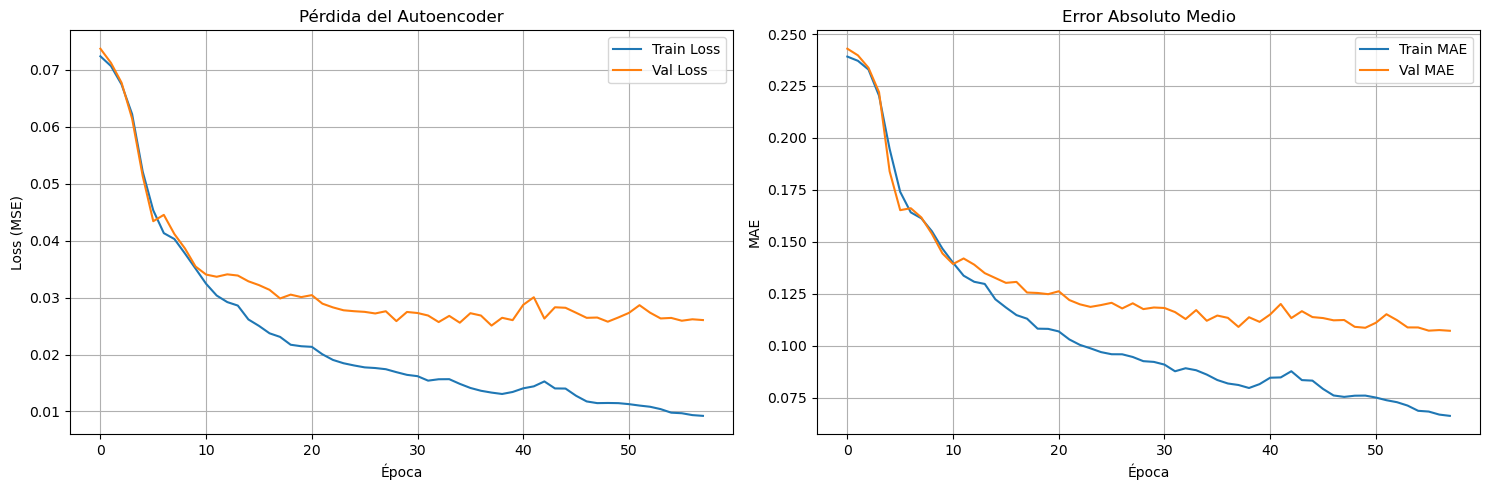

In [10]:
# Visualizar curvas de entrenamiento del autoencoder
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_ae.history['loss'], label='Train Loss')
axes[0].plot(history_ae.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Pérdida del Autoencoder')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history_ae.history['mae'], label='Train MAE')
axes[1].plot(history_ae.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].set_title('Error Absoluto Medio')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


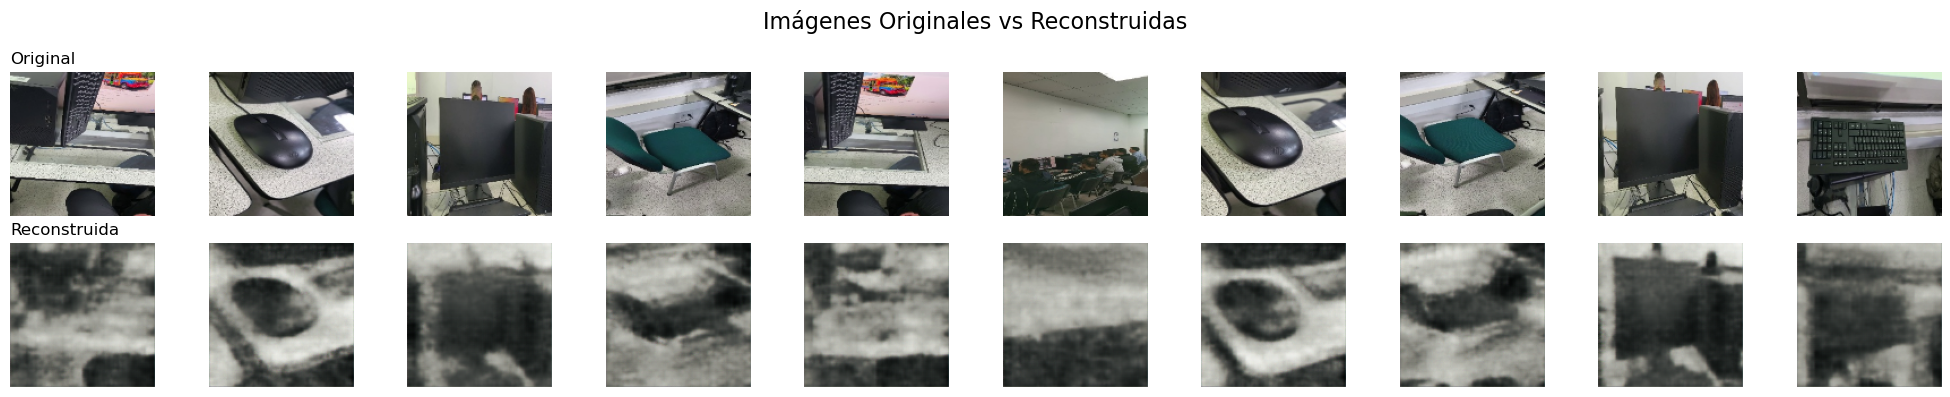

In [11]:
# Visualizar reconstrucciones
n_examples = min(10, len(X_val))
test_indices = np.random.choice(len(X_val), n_examples, replace=False)
test_images = X_val[test_indices]

reconstructed = autoencoder.predict(test_images)

fig, axes = plt.subplots(2, n_examples, figsize=(20, 4))
fig.suptitle('Imágenes Originales vs Reconstruidas', fontsize=16)

for i in range(n_examples):
    axes[0, i].imshow(test_images[i])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', loc='left')
    
    axes[1, i].imshow(reconstructed[i])
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstruida', loc='left')

plt.tight_layout()
plt.show()

## 3. Extraer Features con el Encoder

In [12]:
# Extraer features
print("🔍 Extrayendo features con el encoder...")

X_train_encoded = encoder.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
X_val_encoded = encoder.predict(X_val, batch_size=BATCH_SIZE, verbose=1)

print(f"\n✅ Features de entrenamiento: {X_train_encoded.shape}")
print(f"✅ Features de validación: {X_val_encoded.shape}")

🔍 Extrayendo features con el encoder...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

✅ Features de entrenamiento: (57, 32)
✅ Features de validación: (11, 32)


## 4. Construcción del Clasificador SIMPLIFICADO

Modelo MUY simplificado para evitar overfitting con pocos datos.

In [13]:
def build_classifier_simple(input_shape=(128, 128, 3), num_classes=7):
    """
    Clasificador SIMPLIFICADO con regularización L2
    Optimizado para datasets MUY pequeños
    """
    model = models.Sequential([
        # Bloque 1 - MUY simple
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01),
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Bloque 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Bloque 3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        # Clasificador simple
        layers.Flatten(),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='classifier_simple')
    
    return model

# Construir el clasificador
classifier = build_classifier_simple(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=NUM_CLASSES
)

print("="*60)
print("CLASIFICADOR SIMPLIFICADO:")
print("="*60)
classifier.summary()

CLASIFICADOR SIMPLIFICADO:


C:\Users\Sebastian\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "classifier_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,727 (8.10 MB)

 Trainable params: 2,122,247 (8.10 MB)

 Non-trainable params: 480 (1.88 KB)

In [14]:
# Compilar el clasificador
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Learning rate más bajo
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

# Callbacks
callbacks_clf = [
    ModelCheckpoint(
        os.path.join(MODEL_DIR, '20242595001_classifier.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Clasificador compilado y listo para entrenar")

✅ Clasificador compilado y listo para entrenar


In [15]:
# Data augmentation MUY AGRESIVO para compensar pocos datos
datagen = ImageDataGenerator(
    rotation_range=30,        # Aumentado de 20 a 30
    width_shift_range=0.3,    # Aumentado de 0.2 a 0.3
    height_shift_range=0.3,   # Aumentado de 0.2 a 0.3
    horizontal_flip=True,
    vertical_flip=True,       # Agregado vertical flip
    zoom_range=0.3,           # Aumentado de 0.2 a 0.3
    brightness_range=[0.7, 1.3],  # Más variación
    shear_range=0.2,          # Agregado shear
    fill_mode='nearest'
)

print("✅ Data augmentation configurado (MUY AGRESIVO para compensar pocos datos)")

✅ Data augmentation configurado (MUY AGRESIVO para compensar pocos datos)


In [16]:
# Entrenar el clasificador
print("🚀 Entrenando clasificador...\n")

# Calcular steps_per_epoch
steps = max(1, len(X_train) // BATCH_SIZE)

history_clf = classifier.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    steps_per_epoch=steps,
    epochs=200,  # Más épocas, pero con early stopping
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks_clf,
    verbose=1
)

🚀 Entrenando clasificador...

Epoch 1/200


C:\Users\Sebastian\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2519 - loss: 4.9792 - top3_acc: 0.6616
Epoch 1: val_accuracy improved from None to 0.27273, saving model to ../models\20242595001_classifier.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2453 - loss: 4.9704 - top3_acc: 0.5094 - val_accuracy: 0.2727 - val_loss: 4.4705 - val_top3_acc: 0.4545 - learning_rate: 5.0000e-04
Epoch 2/200
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2500 - loss: 5.0124 - top3_acc: 0.5000
Epoch 2: val_accuracy did not improve from 0.27273


C:\Users\Sebastian\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2500 - loss: 5.0124 - top3_acc: 0.5000 - val_accuracy: 0.0909 - val_loss: 4.4688 - val_top3_acc: 0.4545 - learning_rate: 5.0000e-04
Epoch 3/200
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1536 - loss: 5.3225 - top3_acc: 0.5192
Epoch 3: val_accuracy did not improve from 0.27273
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1132 - loss: 5.3923 - top3_acc: 0.4717 - val_accuracy: 0.0000e+00 - val_loss: 4.4896 - val_top3_acc: 0.5455 - learning_rate: 5.0000e-04
Epoch 4/200
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2500 - loss: 5.1800 - top3_acc: 0.2500
Epoch 4: val_accuracy did not improve from 0.27273
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2500 - loss: 5.1800 - top3_acc: 0.2500 - val_accuracy: 0.0000e+00 - val_loss: 4.4980 - val_top3_acc: 0.3636 - learning_rate: 5.0000e-04
Epoch 5/200
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1505 - loss: 5.3968 - top3_acc: 0.4439
Epoch 5: val_accura

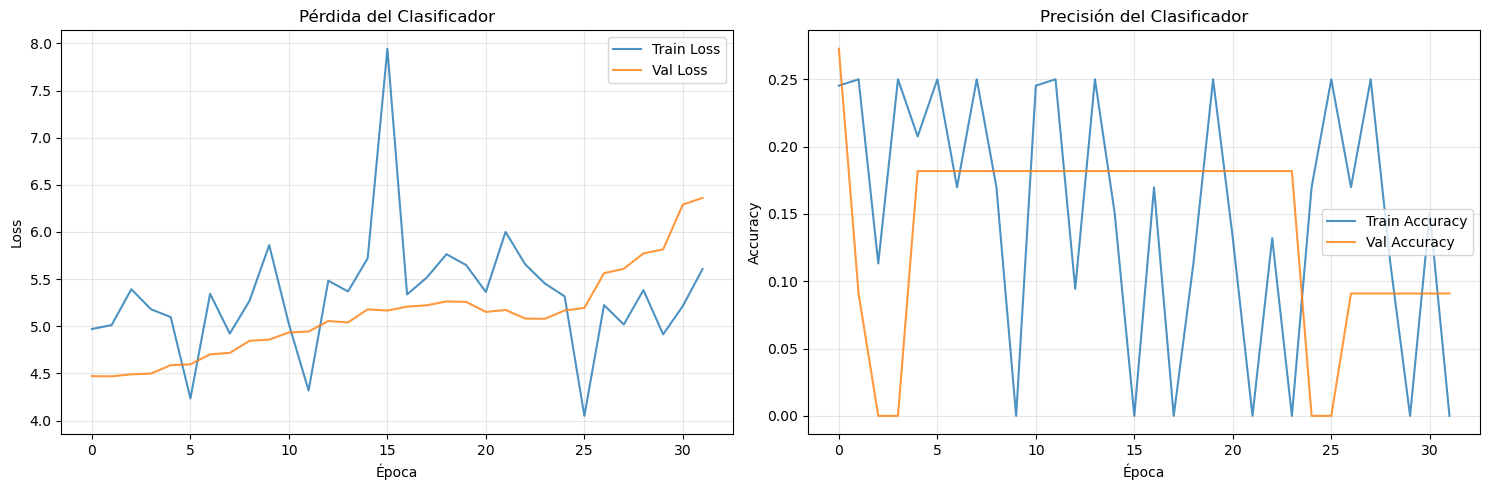

In [17]:
# Visualizar curvas de entrenamiento del clasificador
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_clf.history['loss'], label='Train Loss', alpha=0.8)
axes[0].plot(history_clf.history['val_loss'], label='Val Loss', alpha=0.8)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdida del Clasificador')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_clf.history['accuracy'], label='Train Accuracy', alpha=0.8)
axes[1].plot(history_clf.history['val_accuracy'], label='Val Accuracy', alpha=0.8)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Precisión del Clasificador')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Evaluación del Modelo

In [18]:
# Evaluar en conjunto de validación
val_loss, val_acc, val_top3 = classifier.evaluate(X_val, y_val_cat, verbose=0)

print(f"📊 Resultados en conjunto de validación:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  Top-3 Accuracy: {val_top3:.4f} ({val_top3*100:.2f}%)")

if val_acc < 0.5:
    print(f"\n⚠️  El accuracy es bajo debido a:")
    print(f"   1. Dataset muy pequeño ({len(X)} imágenes total)")
    print(f"   2. Solo {len(X_val)} imágenes de validación")
    print(f"   3. Necesitas extraer más frames de tus videos")
else:
    print(f"\n✅ ¡Buen resultado considerando el dataset pequeño!")

📊 Resultados en conjunto de validación:
  Loss: 4.4688
  Accuracy: 0.0909 (9.09%)
  Top-3 Accuracy: 0.4545 (45.45%)

⚠️  El accuracy es bajo debido a:
   1. Dataset muy pequeño (68 imágenes total)
   2. Solo 11 imágenes de validación
   3. Necesitas extraer más frames de tus videos


In [19]:
# Predicciones
y_pred = classifier.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reporte de clasificación
print("\n📋 Reporte de Clasificación:")
print("="*70)
print(classification_report(y_val, y_pred_classes, target_names=CLASSES, zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

     teclado       0.00      0.00      0.00         1
       mouse       0.00      0.00      0.00         2
    pantalla       0.00      0.00      0.00         2
         cpu       0.00      0.00      0.00         1
       silla       0.00      0.00      0.00         2
        mesa       0.00      0.00      0.00         2
        nada       0.10      1.00      0.18         1

    accuracy                           0.09        11
   macro avg       0.01      0.14      0.03        11
weighted avg       0.01      0.09      0.02        11



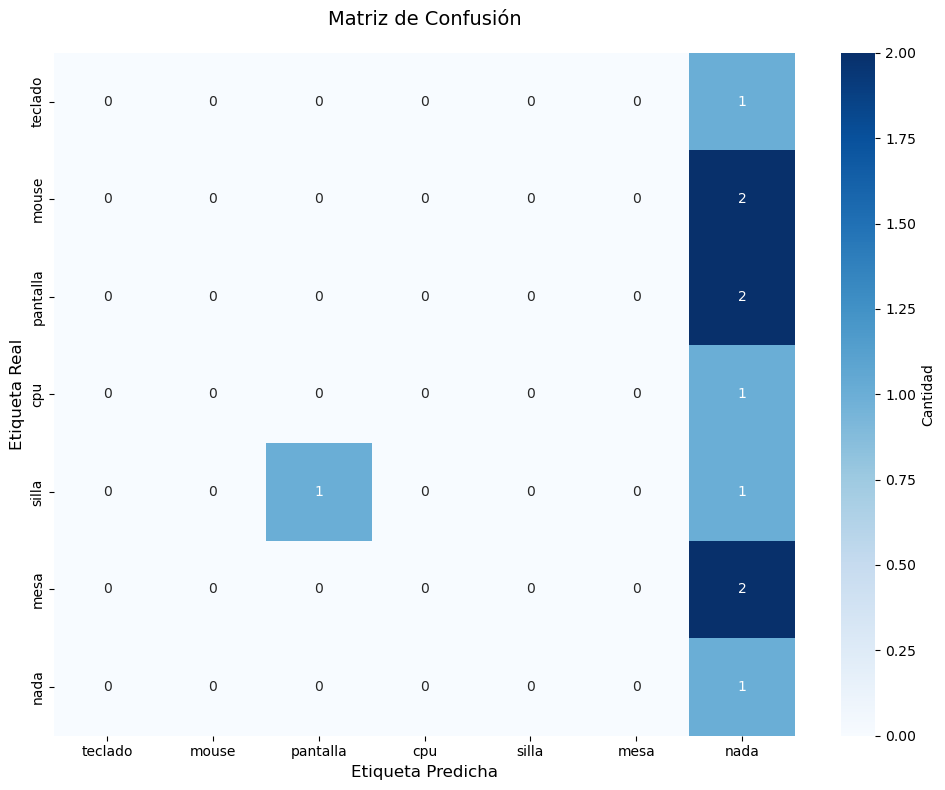

In [20]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión', fontsize=14, pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.show()

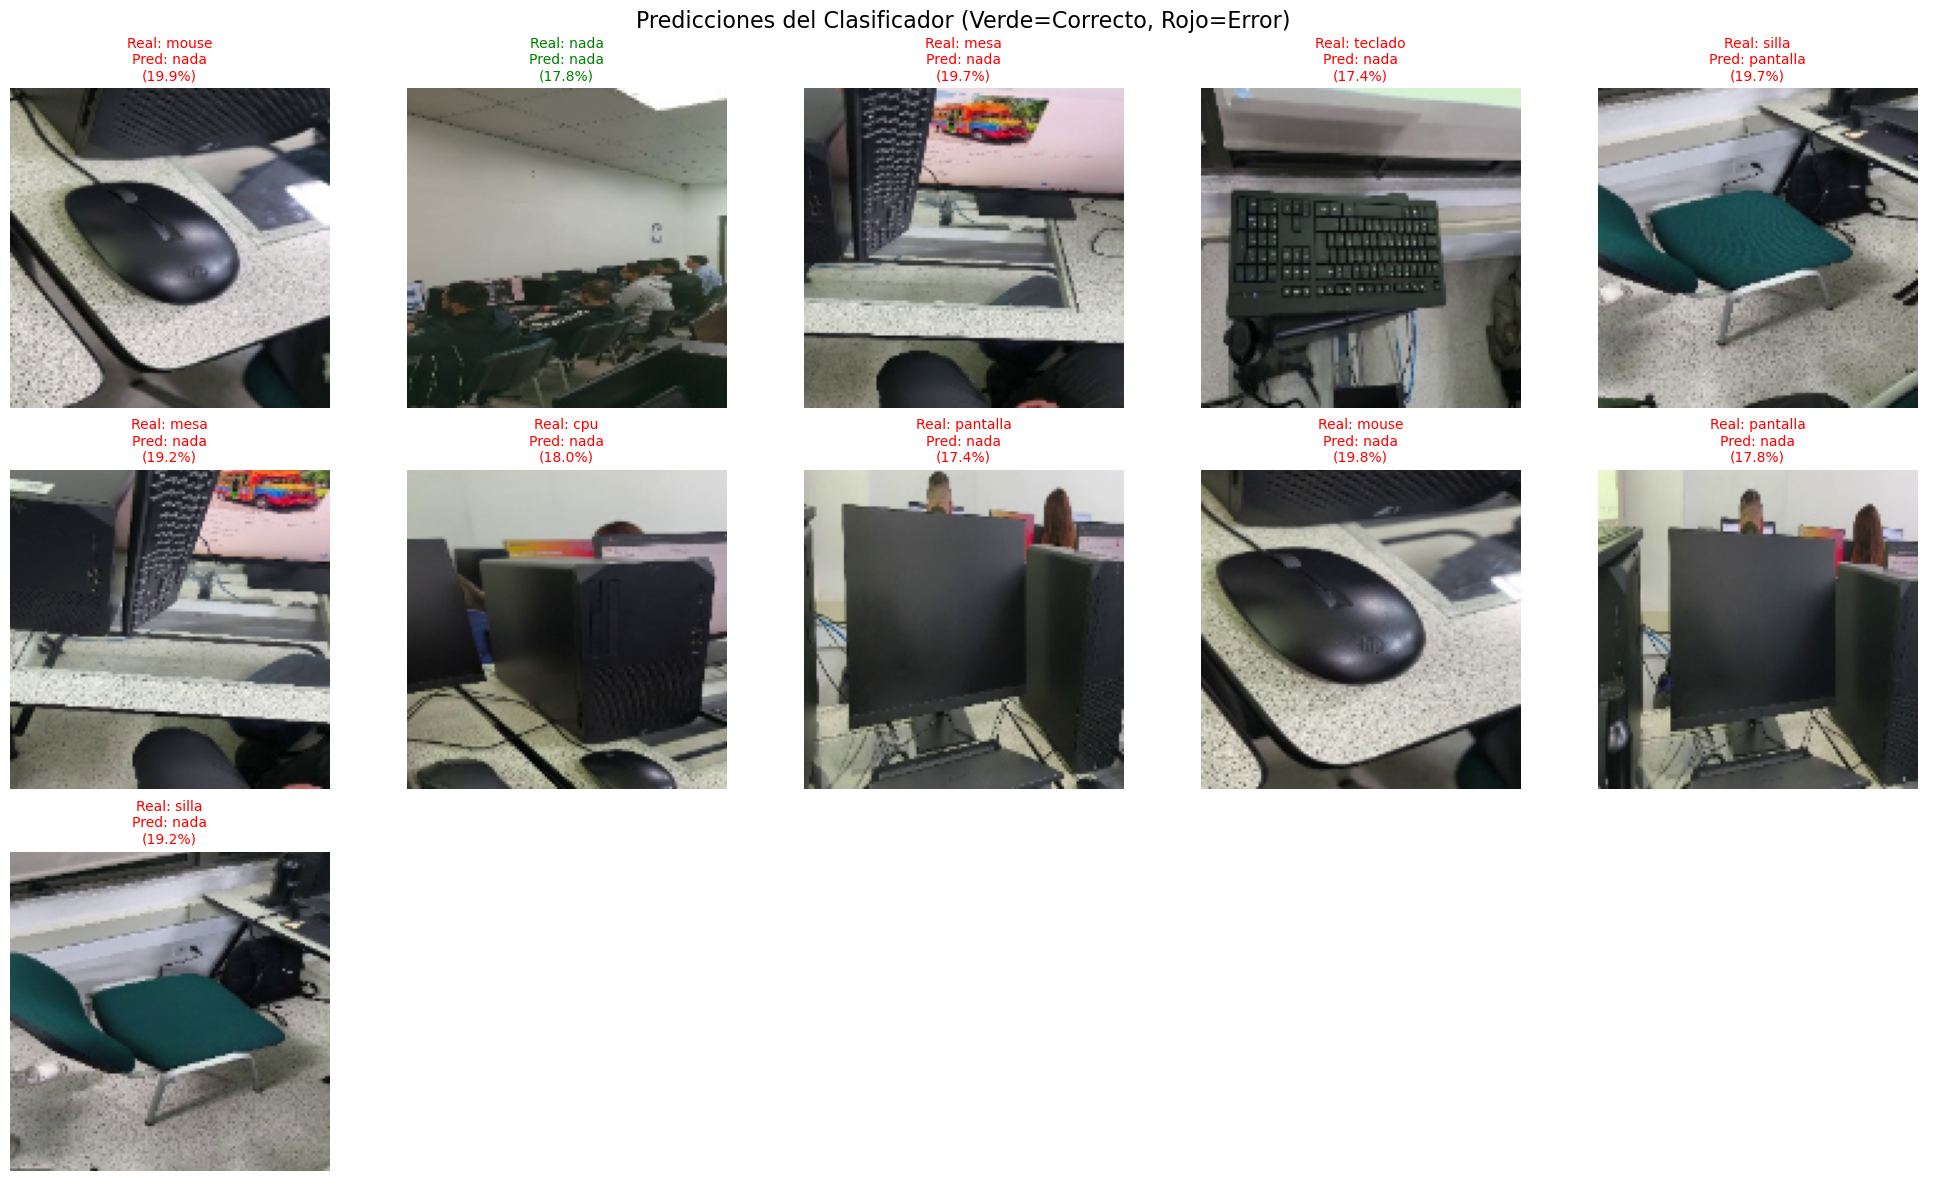

In [21]:
# Visualizar TODAS las predicciones de validación
n_examples = len(X_val)
n_cols = 5
n_rows = (n_examples + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.ravel()

for i in range(n_examples):
    axes[i].imshow(X_val[i])
    
    true_label = CLASSES[y_val[i]]
    pred_label = CLASSES[y_pred_classes[i]]
    confidence = y_pred[i][y_pred_classes[i]] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    
    axes[i].set_title(
        f"Real: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)",
        color=color,
        fontsize=10
    )
    axes[i].axis('off')

# Ocultar ejes vacíos
for i in range(n_examples, len(axes)):
    axes[i].axis('off')

plt.suptitle('Predicciones del Clasificador (Verde=Correcto, Rojo=Error)', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Visualización del Espacio Latente

🔍 Calculando t-SNE del espacio latente...


c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _wina

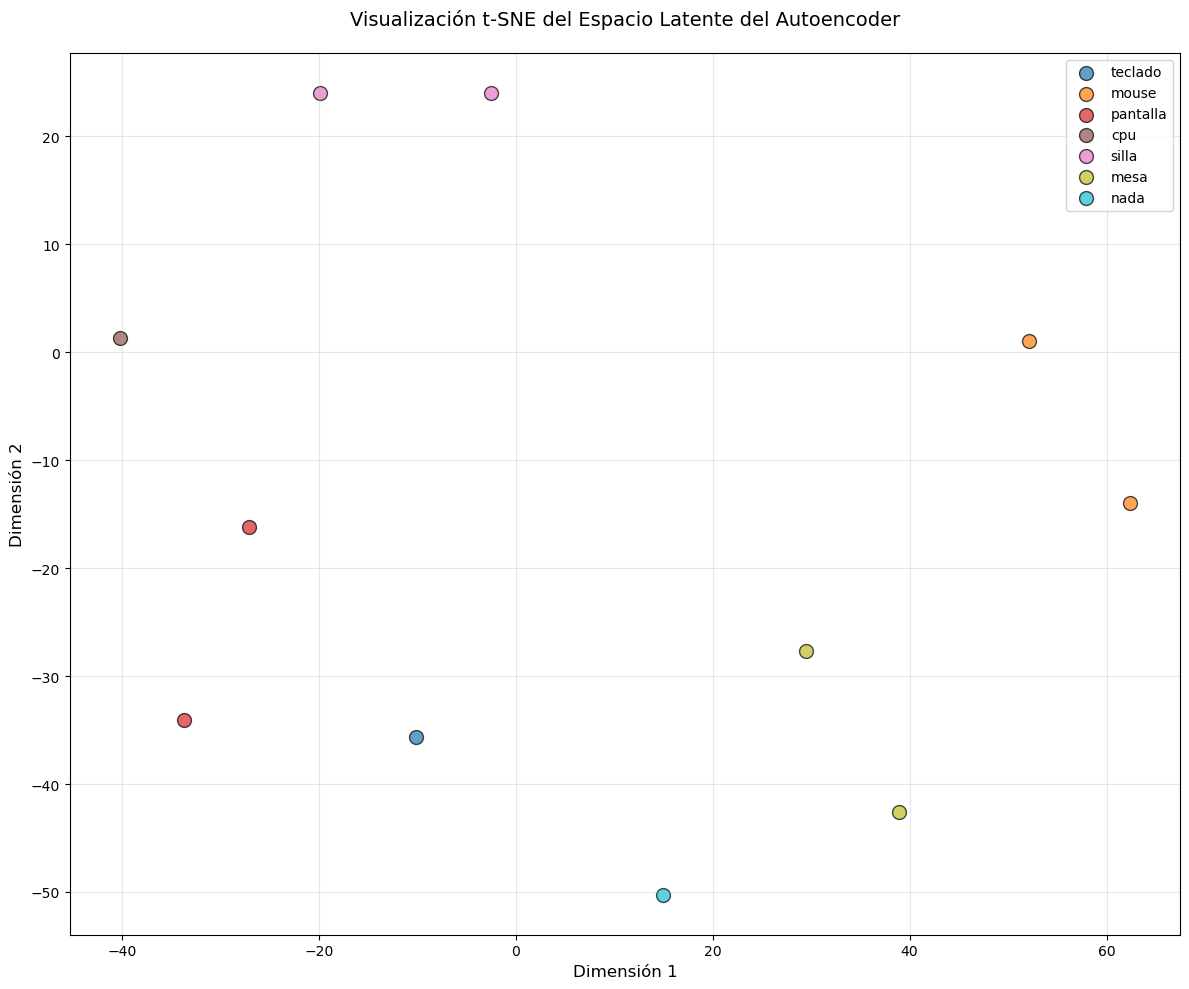

In [22]:
# Reducir dimensionalidad con t-SNE solo si hay suficientes datos
if len(X_val_encoded) >= 5:
    from sklearn.manifold import TSNE
    
    print("🔍 Calculando t-SNE del espacio latente...")
    
    # Ajustar perplexity según el tamaño del dataset
    perplexity = min(5, len(X_val_encoded) - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_val_tsne = tsne.fit_transform(X_val_encoded)
    
    # Visualizar
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))
    
    for class_idx, class_name in enumerate(CLASSES):
        mask = y_val == class_idx
        if np.any(mask):
            plt.scatter(
                X_val_tsne[mask, 0],
                X_val_tsne[mask, 1],
                c=[colors[class_idx]],
                label=class_name,
                alpha=0.7,
                s=100,
                edgecolors='black',
                linewidths=1
            )
    
    plt.title('Visualización t-SNE del Espacio Latente del Autoencoder', fontsize=14, pad=20)
    plt.xlabel('Dimensión 1', fontsize=12)
    plt.ylabel('Dimensión 2', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No hay suficientes datos para t-SNE")

## 7. Guardar Modelos

In [23]:
print("💾 Guardando modelos finales...\n")

# Crear directorio si no existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Guardar autoencoder completo
autoencoder.save(os.path.join(MODEL_DIR, '20242595001_autoencoder_final.h5'))
print(f"  ✅ Autoencoder guardado")

# Guardar solo el encoder
encoder.save(os.path.join(MODEL_DIR, '20242595001_encoder.h5'))
print(f"  ✅ Encoder guardado")

# Guardar clasificador
classifier.save(os.path.join(MODEL_DIR, '20242595001_classifier_final.h5'))
print(f"  ✅ Clasificador guardado")

print("\n🎉 ¡Todos los modelos guardados exitosamente!")

💾 Guardando modelos finales...

  ✅ Autoencoder guardado
  ✅ Encoder guardado
  ✅ Clasificador guardado

🎉 ¡Todos los modelos guardados exitosamente!


## 8. Función para Predecir Nuevas Imágenes

In [24]:
def predict_image(image_path, classifier, show_plot=True):
    """
    Predice la clase de una imagen
    """
    # Cargar imagen
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized.astype('float32') / 255.0
    
    # Predecir
    img_batch = np.expand_dims(img_normalized, axis=0)
    predictions = classifier.predict(img_batch, verbose=0)[0]
    
    # Obtener clase predicha
    pred_class_idx = np.argmax(predictions)
    pred_class = CLASSES[pred_class_idx]
    confidence = predictions[pred_class_idx] * 100
    
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Mostrar imagen
        axes[0].imshow(img_resized)
        axes[0].set_title(f"Predicción: {pred_class} ({confidence:.1f}%)", fontsize=14)
        axes[0].axis('off')
        
        # Mostrar probabilidades
        bars = axes[1].barh(CLASSES, predictions * 100)
        bars[pred_class_idx].set_color('green')
        axes[1].set_xlabel('Probabilidad (%)', fontsize=12)
        axes[1].set_title('Probabilidades de cada clase', fontsize=14)
        axes[1].set_xlim([0, 100])
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
    
    return pred_class, confidence, predictions

print("✅ Función de predicción lista para usar")
print("\nEjemplo de uso:")
print("  pred_class, confidence, probs = predict_image('ruta/a/imagen.jpg', classifier)")

✅ Función de predicción lista para usar

Ejemplo de uso:
  pred_class, confidence, probs = predict_image('ruta/a/imagen.jpg', classifier)


## 9. Resumen y Recomendaciones

### ✅ Mejoras Implementadas:

1. **Modelo simplificado**: Menos parámetros para evitar overfitting
2. **Imagen más pequeña**: 128x128 en vez de 224x224
3. **Batch size reducido**: 4 en vez de 32
4. **Regularización L2**: En todas las capas convolucionales
5. **Data augmentation agresivo**: Más transformaciones
6. **Learning rate más bajo**: 0.0005 en vez de 0.001
7. **Más epochs**: 200 con early stopping

### 📈 Para Mejorar Aún Más:

Si el accuracy sigue siendo bajo (<50%), necesitas:

1. **Extraer MÁS frames de tus videos**:
   ```python
   # Modificar extract_frames.py con frame_interval=3 en vez de 12
   # Esto te dará ~4x más frames
   ```

2. **Grabar videos más largos**: 5-10 segundos en vez de 1-3

3. **Grabar desde diferentes ángulos**: Para cada objeto

4. **Verificar la calidad**: Videos claros, bien iluminados

### 🎯 Métricas Realistas:

Con ~70 imágenes (10 por clase):
- **Malo**: <40% accuracy
- **Aceptable**: 40-60% accuracy
- **Bueno**: 60-75% accuracy
- **Excelente**: >75% accuracy

Con ~200+ imágenes (30+ por clase):
- Puedes esperar 80-95% accuracy
